In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import sys
import os
import pydicom
import pickle

from PIL import Image

from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

In [2]:
def train(network, data, epochs, learning_rate, l2=0):
    loss = nn.MSELoss()
    #SGD
    network.cuda()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=l2)
    train, test = train_test_split(data)
    train_loader = DataLoader(train, batch_size=50, shuffle=True)
    test_loader = DataLoader(test, batch_size=50, shuffle=True)
    res = 0
    try:
        for epoch in range(epochs):
            train_losses = []
            train_accuracies = []
            
            for X in train_loader:
                X = Variable(X)
                X = X.float()
                X = X.cuda()
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, X)
                loss_batch.backward()
                optimizer.step()
                train_losses.append(loss_batch.item())
                
                prediction = prediction.cpu()
                X = X.cpu()
                
                train_accuracies.append(np.absolute((prediction.data.numpy() - X.data.numpy())).sum()) 
            train_losses = np.mean(train_losses)
            train_accuracies = np.mean(train_accuracies)
            
            
            test_losses = []
            test_accuracies = []
            for X in test_loader:
                X = Variable(X)
                X = X.float()
                X = X.cuda()
                prediction = network(X)
                loss_batch = loss(prediction, X)
                test_losses.append(loss_batch.item())
                
                prediction = prediction.cpu()
                X = X.cpu()
                
                test_accuracies.append(np.absolute((prediction.data.numpy() - X.data.numpy())).sum())
            
            test_losses = np.mean(test_losses)
            test_accuracies = np.mean(test_accuracies)
            
            res = (train_losses, test_losses, train_accuracies, test_accuracies)
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_losses, test_losses,
                        train_accuracies, test_accuracies))
        
    except KeyboardInterrupt:
        pass
    network.cpu()
    return res

In [120]:
def just_train(network, train, test, epochs, learning_rate, l2=0):
    loss = nn.MSELoss()
    #SGD
    network.cuda()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=l2)
    train_loader = DataLoader(train, batch_size=50, shuffle=True)
    test_loader = DataLoader(test, batch_size=50, shuffle=True)
    res = 0
    try:
        for epoch in range(epochs):
            train_losses = []
            train_accuracies = []
            
            for X in train_loader:
                X = Variable(X)
                X = X.float()
                X = X.cuda()
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, X)
                loss_batch.backward()
                optimizer.step()
                train_losses.append(loss_batch.item())
                
                prediction = prediction.cpu()
                X = X.cpu()
                
                train_accuracies.append(np.absolute((prediction.data.numpy() - X.data.numpy())).sum()) 
            train_losses = np.mean(train_losses)
            train_accuracies = np.mean(train_accuracies)
            
            
            test_losses = []
            test_accuracies = []
            for X in test_loader:
                X = Variable(X)
                X = X.float()
                X = X.cuda()
                prediction = network(X)
                loss_batch = loss(prediction, X)
                test_losses.append(loss_batch.item())
                
                prediction = prediction.cpu()
                X = X.cpu()
                
                test_accuracies.append(np.absolute((prediction.data.numpy() - X.data.numpy())).sum())
            
            test_losses = np.mean(test_losses)
            test_accuracies = np.mean(test_accuracies)
            
            res = (train_losses, test_losses, train_accuracies, test_accuracies)
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_losses, test_losses,
                        train_accuracies, test_accuracies))
        
    except KeyboardInterrupt:
        pass
    network.cpu()
    return res

In [3]:
def check_models(X, y, metric='accuracy'):
    res = {'LogisticRegression': 0,
           'DecisionTree': 0,
           'GaussianNB': 0,
           'SVC': 0,
           'SGD': 0,
           'GaussianProcess': 0,
           'XGBoost': 0
          }
    #print metric
    X, y = shuffle(X, y)
    lg = LogisticRegression(solver='liblinear', multi_class='auto')
    cv = cross_validate(lg, X, y, cv=5, scoring=metric)
    res['LogisticRegression'] = np.mean(cv['test_score'])
    
    dt = DecisionTreeClassifier(criterion='gini')
    cv = cross_validate(dt, X, y, cv=5)
    res['DecisionTree'] = np.mean(cv['test_score'])
    
    bayes = GaussianNB()
    cv = cross_validate(bayes, X, y, cv=5, scoring=metric)
    res['GaussianNB'] = np.mean(cv['test_score'])
    
    svc = SVC(kernel='rbf', shrinking=True, probability=False, degree=3, gamma='auto')
    cv = cross_validate(svc, X, y, cv=5, scoring=metric)
    res['SVC'] = np.mean(cv['test_score'])
    
    sgd = SGDClassifier(tol=1e-3, max_iter=1000, loss='hinge')
    cv = cross_validate(sgd, X, y, cv=5, scoring=metric)
    res['SGD'] = np.mean(cv['test_score'])
    
    gp = GaussianProcessClassifier()
    cv = cross_validate(gp, X, y, cv=5, scoring=metric)
    res['GaussianProcess'] = np.mean(cv['test_score'])
    
    #gb = XGBClassifier(max_depth=10, n_estimators=20, booster='dart')
    #cv = cross_validate(gb, X, y, cv=10, scoring=metric)
    #res['XGBoost'] = np.mean(cv['test_score'])
    
    return res

In [94]:
class MyAutoencoder64(nn.Module):
    def __init__(self, n_comp=10):
        super(MyAutoencoder64, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(4096, 500), nn.Sigmoid(), 
        nn.Linear(500, 64), nn.Sigmoid(), 
        nn.Linear(64, n_comp))
        self.decoder = nn.Sequential(nn.Linear(n_comp, 64), nn.Tanh(), 
        nn.Linear(64, 500), nn.Tanh(), 
        nn.Linear(500, 4096))
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)

        return x.data.numpy()

In [95]:
class MySparceAutoencoder64(nn.Module):
    def __init__(self, n_comp=10):
        super(MySparceAutoencoder64, self).__init__()
        self.n_comp = n_comp

        self.encoder = nn.Sequential(nn.Linear(4096, 1000), nn.Sigmoid(), 
        nn.Linear(1000, 500), nn.Sigmoid(), 
        nn.Linear(500, 100))
        self.decoder = nn.Sequential(nn.Linear(100, 500), nn.Tanh(), 
        nn.Linear(500, 1000), nn.Tanh(), 
        nn.Linear(1000, 4096))

    def forward(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0

        return x.data.numpy()

In [96]:
class MyDeepAutoencoder64(nn.Module):
    def __init__(self, n_comp=10):
        super(MyDeepAutoencoder64, self).__init__()
        self.n_comp = n_comp
        
        self.encoder = nn.Sequential(nn.Linear(4096, 2000), nn.Sigmoid(), 
        nn.Linear(2000, 1100), nn.Sigmoid(), 
        nn.Linear(1100, 500), nn.Sigmoid(), 
        nn.Linear(500, 300), nn.Sigmoid(), 
        nn.Linear(300, 100), nn.Sigmoid(), 
        nn.Linear(100, n_comp))
        self.decoder = nn.Sequential(nn.Linear(n_comp, 100), nn.Tanh(), 
        nn.Linear(100, 300), nn.Tanh(),
        nn.Linear(300, 500), nn.Tanh(),
        nn.Linear(500, 1100), nn.Tanh(),
        nn.Linear(1100, 2000), nn.Tanh(), 
        nn.Linear(2000, 4096))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)

        return x.data.numpy()

In [97]:
class MyDeepSparceAutoencoder64(nn.Module):
    def __init__(self, n_comp=10):
        super(MyDeepSparceAutoencoder64, self).__init__()
        self.n_comp = n_comp

        self.encoder = nn.Sequential(nn.Linear(4096, 2000), nn.Sigmoid(), 
        nn.Linear(2000, 1100), nn.Sigmoid(), 
        nn.Linear(1100, 500), nn.Sigmoid(), 
        nn.Linear(500, 300), nn.Sigmoid(), 
        nn.Linear(300, 100))
        self.decoder = nn.Sequential( 
        nn.Linear(100, 300), nn.Tanh(),
        nn.Linear(300, 500), nn.Tanh(),
        nn.Linear(500, 1100), nn.Tanh(),
        nn.Linear(1100, 2000), nn.Tanh(), 
        nn.Linear(2000, 4096))

    def forward(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0

        return x.data.numpy()

In [98]:
class MyAutoencoder128(nn.Module):
    def __init__(self, n_comp=10):
        super(MyAutoencoder128, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(16384, 5000), nn.Sigmoid(), 
        nn.Linear(5000, 1000),nn.Sigmoid(), 
        nn.Linear(1000, 300), nn.Sigmoid(), 
        nn.Linear(300, 60), nn.Sigmoid(), 
        nn.Linear(60, n_comp))
        self.decoder = nn.Sequential(nn.Linear(n_comp, 60), nn.Tanh(), 
        nn.Linear(60, 300), nn.Tanh(),
        nn.Linear(300, 1000), nn.Tanh(),
        nn.Linear(1000, 5000), nn.Tanh(), 
        nn.Linear(5000, 16384))
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0

        return x.data.numpy()

In [37]:
class MySparceAutoencoder128(nn.Module):
    def __init__(self, n_comp=10):
        super(MySparceAutoencoder128, self).__init__()
        self.n_comp = n_comp
        self.encoder = nn.Sequential(nn.Linear(16384, 5000), nn.Sigmoid(), 
        nn.Linear(5000, 1000),nn.Sigmoid(), 
        nn.Linear(1000, 300), nn.Sigmoid(), 
        nn.Linear(300, 100))
        self.decoder = nn.Sequential(nn.Linear(100, 300), nn.Tanh(), 
        nn.Linear(300, 1000), nn.Tanh(),
        nn.Linear(1000, 5000), nn.Tanh(), 
        nn.Linear(5000, 16384))

    def forward(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0
        x = self.decoder(x)

        return x

    def encode(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0

        return x.data.numpy()

In [10]:
class MyDeepAutoencoder128(nn.Module):
    def __init__(self, n_comp=10):
        super(MyDeepAutoencoder128, self).__init__()
        self.n_comp = n_comp
        self.encoder = nn.Sequential(nn.Linear(16384, 10000), nn.Sigmoid(), 
        nn.Linear(10000, 6000),nn.Sigmoid(), 
        nn.Linear(6000, 2000), nn.Sigmoid(), 
        nn.Linear(2000, 800), nn.Sigmoid(), 
        nn.Linear(800, 300), nn.Sigmoid(), 
        nn.Linear(300, 100), nn.Sigmoid(), 
        nn.Linear(100, n_comp))
        self.decoder = nn.Sequential(nn.Linear(n_comp, 100), nn.Tanh(), 
        nn.Linear(100, 300), nn.Tanh(),
        nn.Linear(300, 800), nn.Tanh(),
        nn.Linear(800, 2000), nn.Tanh(),
        nn.Linear(2000, 6000), nn.Tanh(),
        nn.Linear(6000, 10000), nn.Tanh(), 
        nn.Linear(10000, 16384))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

    def encode(self, x):
        x = self.encoder(x)
        return x.data.numpy()

In [11]:
class MyDeepSparceAutoencoder128(nn.Module):
    def __init__(self, n_comp=10):
        super(MyDeepSparceAutoencoder128, self).__init__()
        self.n_comp = n_comp
        self.encoder = nn.Sequential(nn.Linear(16384, 10000), nn.Sigmoid(), 
        nn.Linear(10000, 6000),nn.Sigmoid(), 
        nn.Linear(6000, 2000), nn.Sigmoid(), 
        nn.Linear(2000, 800), nn.Sigmoid(), 
        nn.Linear(800, 300), nn.Sigmoid(), 
        nn.Linear(300, 100))
        self.decoder = nn.Sequential(nn.Linear(100, 300), nn.Tanh(),
        nn.Linear(300, 800), nn.Tanh(),
        nn.Linear(800, 2000), nn.Tanh(),
        nn.Linear(2000, 6000), nn.Tanh(),
        nn.Linear(6000, 10000), nn.Tanh(), 
        nn.Linear(10000, 16384))

    def forward(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0
        x = self.decoder(x)
        
        return x

    def encode(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0

        return x.data.numpy()

In [112]:
class MyCAutoencoder(nn.Module):
    def __init__(self, n_comp=16):
        super(MyCAutoencoder, self).__init__()
        self.n_comp = n_comp
        self.ec1 = nn.Conv2d(1,2,(3,3),padding=1) 
        self.ep1 = nn.MaxPool2d(4, return_indices=True) 
        self.ec2 = nn.Conv2d(2,4,(3,3),padding=1)
        self.ep2 = nn.MaxPool2d(2, return_indices=True)
        self.ec3 = nn.Conv2d(4,n_comp,(3,3),padding=1)
        self.ep3 = nn.MaxPool2d(4, return_indices=True)
        self.el = nn.Linear(4,4)
        self.ep4 = nn.MaxPool2d(4, return_indices=True)
        
        self.dp4 = nn.MaxUnpool2d(4)
        self.dl = nn.Linear(4,4)
        self.dp3 = nn.MaxUnpool2d(4)
        self.dc3 = nn.Conv2d(n_comp,4,(3,3),padding=1) 
        self.dp2 = nn.MaxUnpool2d(2)
        self.dc2 = nn.Conv2d(4,2,(3,3),padding=1)
        self.dp1 = nn.MaxUnpool2d(4)
        self.dc1 = nn.Conv2d(2,1,(3,3),padding=1)
        
    def forward(self, x):
        relu = nn.ReLU()
        #encode
        x = self.ec1(x)
        x, i1 = self.ep1(x)
        x = relu(x)
        x = self.ec2(x)
        x, i2 = self.ep2(x)
        x = relu(x)
        x = self.ec3(x)
        x, i3 = self.ep3(x)
        x = relu(x)
        x = self.el(x)
        x, i4 = self.ep4(x)
        
        x = self.dp4(x, i4)
        x = self.dl(x)
        x = relu(x)
        x = self.dp3(x, i3)
        x = self.dc3(x)
        x = relu(x)
        x = self.dp2(x, i2)
        x = self.dc2(x)
        x = relu(x)
        x = self.dp1(x, i1)
        x = self.dc1(x)

        
        return x
    def encode(self, x):
        relu = nn.ReLU()
        
        x = self.ec1(x)
        x, i1 = self.ep1(x)
        x = relu(x)
        x = self.ec2(x)
        x, i2 = self.ep2(x)
        x = relu(x)
        x = self.ec3(x)
        x, i3 = self.ep3(x)
        x = relu(x)
        x = self.el(x)
        x, i4 = self.ep4(x)
        
        return x.data.numpy().reshape(-1, self.n_comp)

In [8]:
N = 200
#d2models64 = [MyAutoencoder64, MySparceAutoencoder64, MyDeepAutoencoder64, MyDeepSparceAutoencoder64]
#d2models128 = [MyAutoencoder128, MySparceAutoencoder128, MyDeepAutoencoder128, MyDeepSparceAutoencoder128]
res = open('out.txt', 'w')
with open('../data/y.pickle', 'rb') as f:
    y = pickle.load(f)
with open('../data/other.pickle', 'rb') as f:
    other = pickle.load(f)

In [58]:
np.array(y).sum() / len(y)

0.8790661650807701

In [15]:
res = open('out.txt', 'w')

In [39]:

with open('d2data64.pickle', 'rb') as f:
    d2data64 = pickle.load(f)
print(d2data64.shape)
d2models64 = [MyAutoencoder64, MySparceAutoencoder64, MyDeepAutoencoder64, MyDeepSparceAutoencoder64]
result = {'MyAutoencoder64':[], 'MySparceAutoencoder64':[], 'MyDeepAutoencoder64':[], 'MyDeepSparceAutoencoder64':[]}
ind = 0
for i in range(10, 17):
    for model in d2models64:
        currmodel = model(i)
        train_loss, test_loss, train_ac, test_ac = train(currmodel, d2data64, N, 0.001)
        res.write('*' * 20 + '\n')
        res.write(str(type(currmodel)) + str(i) + '\n')
        res.write('(Train/Test) MSE: {0:.3f}/{1:.3f}\tAccuracy: {2:.3f}/{3:.3f}\n'.format(
                    train_loss, test_loss,
                    train_ac, test_ac))
    
        X1 = currmodel.encode(Variable(torch.Tensor(d2data64)))
        #X1 = pd.DataFrame(X1)
        #data = pd.concat([X1, other], axis=1)
        f1 = check_models(X1, y, metric='f1')
        if ind == 0:
            result[]
        
        res.write(str(f1) + '\n')

del d2data64
gc.collect()






(9038, 4096)
Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10885.715/10822.426

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.029/0.030	Accuracy: 23811.740/25071.557

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10809.850/10683.635

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.030/0.029	Accuracy: 24534.979/23494.062

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10687.960/10775.550

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.021/0.021	Accuracy: 17829.271/17372.400

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10653.196/10620.190

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.029/0.029	Accuracy: 23890.125/23669.736

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10755.103/10708.17375

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.021/0.021	Accuracy: 17698.867/17810.520

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10853.759/10778.4639

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.029/0.031	Accuracy: 24039.426/24506.869

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10752.287/10610.707

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.029/0.031	Accuracy: 24084.791/23983.307

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.021/0.021	Accuracy: 17811.312/17241.809

NameError: name 'gc' is not defined

In [ ]:
with open('../data/d2data128.pickle', 'rb') as f:
    d2data128 = pickle.load(f)

for i in range(10, 17):
    for model in d2models128:
        currmodel = model(i)
        train_loss, test_loss, train_ac, test_ac = train(model, d2data128, N, 0.001)
        res.write('*' * 20 + '\n')
        res.write(str(type(currmodel)) + str(i) + '\n')
        res.write('(Train/Test) MSE: {0:.3f}/{1:.3f}\tAccuracy: {2:.3f}/{3:.3f}\n'.format(
                    train_loss, test_loss,
                    train_ac, test_ac))
    
        X1 = currmodel.encode(Variable(torch.Tensor(d2data64)))
        X1 = pd.DataFrame(X1)
        data = pd.concat([X1, other], axis=1)
        f1 = check_models(data, y, metric='f1')

        res.write(str(f1) + '\n')

del d2data64
gc.collect()

In [16]:
with open('../data/d3data128.pickle', 'rb') as f:
    d3data128 = pickle.load(f)

for i in range(10, 17):
    currmodel = MyCAutoencoder(i)
    train_loss, test_loss, train_ac, test_ac = train(currmodel, d3data128, N, 0.001)
    res.write('*' * 20 + '\n')
    res.write(str(type(currmodel)) + str(i) + '\n')
    res.write('(Train/Test) MSE: {0:.3f}/{1:.3f}\tAccuracy: {2:.3f}/{3:.3f}\n'.format(
                train_loss, test_loss,
                train_ac, test_ac))
    
    test_loader = DataLoader(torch.Tensor(d3data128), batch_size=1000, shuffle=False)
    X1 = None
    for i in test_loader:
        X = currmodel.encode(i)
        if X1 is None:
            X1 = X
        else:
            X1 = np.concatenate((X1, X))
            
    X1 = pd.DataFrame(X1)
    data = pd.concat([X1, other], axis=1)
    f1 = check_models(data, y, metric='f1')
    res.write(str(f1) + '\n')
    break
res.close()

Epoch 199... (Train/Test) MSE: 0.024/0.024	Accuracy: 95773.891/93910.859

In [36]:
test_loader = DataLoader(torch.Tensor(d3data128), batch_size=1000, shuffle=False)
X1 = None
for i in test_loader:
    X = currmodel.encode(i)
    if X1 is None:
        X1 = X
    else:
        X1 = np.concatenate((X1, X))

In [35]:
X.shape

(1000, 10)

In [51]:
X1 = pd.DataFrame(X1.reshape(-1, 10))
data = pd.concat([X1, other], axis=1)
f1 = check_models(data, y, metric='f1')
res.write(str(f1) + '\n')

175

In [10]:
f1

{'LogisticRegression': 0.9351260798593881,
 'DecisionTree': 0.9977871208819193,
 'GaussianNB': 0.7987294269570253,
 'SVC': 0.9836311801778077,
 'SGD': 0.9219453051935576,
 'GaussianProcess': 0.9930793150854988,
 'XGBoost': 0}

In [17]:
f = open('out.txt')
cur = 0
result = {}
for l in f:
    if cur == 0:
        pass
    elif cur == 1:
        model = (l[7:].split('>')[0], int(l[7:].split('>')[1]))
    elif cur == 2:
        pass
    elif cur == 3:
        res = {}
        l = l[1:-2]
        for i in l.split(','):
            res[i.split(':')[0]] = float(i.split(':')[1])
        for a, b in res.items():
            if 'XGBoost' in a:
                continue
            try:
                result[model[0]][a].append(b)
            except:
                try:
                    result[model[0]][a] = []
                    result[model[0]][a].append(b)
                except:
                    result[model[0]] = {}
                    result[model[0]][a] = []
                    result[model[0]][a].append(b)
    cur = (cur + 1) % 4
print(result)

{"'__main__.MyAutoencoder64'": {"'LogisticRegression'": [0.9347364994687926, 0.9361354797295549, 0.9359968205116143, 0.9350156658815901, 0.9359989608592658, 0.9352741398504136, 0.9345006188998815], " 'DecisionTree'": [0.9981192223978494, 0.9990052801282404, 0.9987829400241777, 0.997676255054467, 0.9982299646397795, 0.9978978606868927, 0.9955738712784447], " 'GaussianNB'": [0.8813056369157524, 0.8743307972072601, 0.8674407335393368, 0.8505178298254339, 0.8627962767673953, 0.7876586212822984, 0.8231459642207973], " 'SVC'": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], " 'SGD'": [0.9034260418115647, 0.9069351762281682, 0.9241600236128911, 0.9243942798626554, 0.8787837628759668, 0.8780296710557849, 0.8760187902491967], " 'GaussianProcess'": [0.9999370673379484, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, "'__main__.MySparceAutoencoder64'": {"'LogisticRegression'": [0.9358621745778384, 0.9355161613142089, 0.9356416602524019, 0.9356416602524019, 0.935516244162802, 0.9356416602524019, 0.9356416602524019], " 'Deci

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline

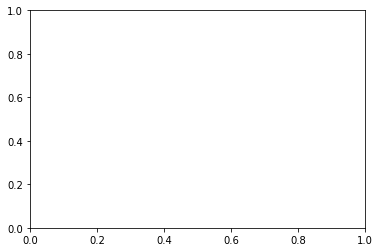

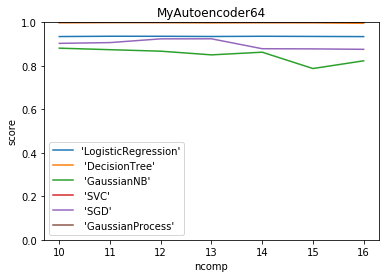

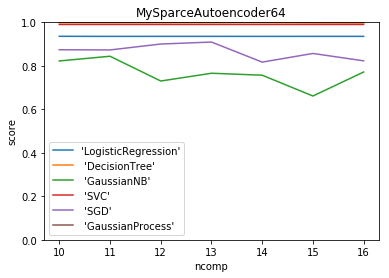

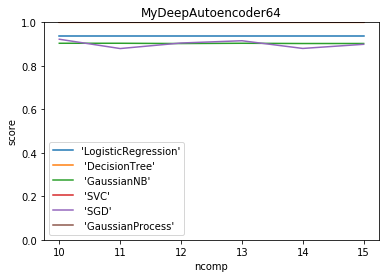

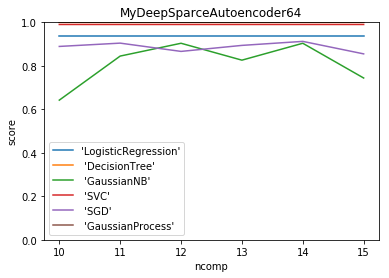

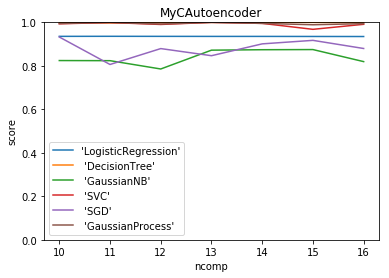

In [21]:
fig, axes = plt.subplots()
for models in result.items():
    fig, axes = plt.subplots()
    for model in models[1].items():
        axes.set_title(models[0][10:-1])
        #axes.set_title('ConvAutoencoder')
        axes.set_ylim(bottom=0.)
        axes.plot(range(10, len(model[1]) + 10), model[1], label=model[0])
        axes.set_ylabel(u'score')
        axes.set_xlabel(u'ncomp')
        axes.legend()

In [271]:
f1

{'LogisticRegression': 0.9356415433419567,
 'DecisionTree': 0.9978976791337523,
 'GaussianNB': 0.863981554068387,
 'SVC': 1.0,
 'SGD': 0.8367419271219682,
 'GaussianProcess': 1.0,
 'XGBoost': 0}

In [54]:
ae = MySparceAutoencoder64(10)

NameError: name 'MySparceAutoencoder64' is not defined

In [56]:
currmodel.encoder[1].weight.data.numpy()

AttributeError: 'Sigmoid' object has no attribute 'weight'

In [5]:
import zipfile

In [38]:
with zipfile.ZipFile('../data/баженов а п.zip', 'r') as MRIs:
    data = []
    other = []
    sh = 64
    count = 0
    for fName in MRIs.namelist():
        if fName[-4:] == '.dcm':
            with MRIs.open(fName) as fileDCM:
                ds = pydicom.read_file(fileDCM)
                
                t = ds[(0x8, 0x103e)].value
                
                if not ('T1' in t or 'T2' in t or 't1' in t or 't2' in t):
                    continue
                
                sex = ds[(0x10, 0x40)].value
                sex = 1 if sex == 'M' else 0
                age = ds[(0x10, 0x1010)].value
                age = int(age[:-1])
                weight = ds[(0x10, 0x1030)].value
                weight = float(weight)
                
                ds = ds.pixel_array
                
                if len(ds.shape) > 2:
                    count += 1
                    continue
        
                other.append([sex, age, weight])
        
                if ds.shape[0] != sh:
                
                    gg = Image.fromarray(ds)
                    gg = gg.resize((sh, sh))
                    curr = np.asarray(gg)
                    
                curr = curr.reshape(sh**2)
                mmax = float(np.max(curr))
                if mmax != 0:
                    curr = curr / mmax 
                    
                data.append(curr)
    data = np.array(data, dtype=float)
    other = np.array(other)

In [154]:
class MyAnotherSparceAutoencoder64(nn.Module):
    def __init__(self, n_comp=10):
        super(MyAnotherSparceAutoencoder64, self).__init__()
        self.n_comp = n_comp

        self.encoder = nn.Sequential(nn.Linear(4096, 1000), nn.Sigmoid(), 
        nn.Linear(1000, 500), nn.Sigmoid(), 
        nn.Linear(500, 100))
        self.decoder = nn.Sequential(nn.Linear(n_comp, 500), nn.Tanh(), 
        nn.Linear(500, 1000), nn.Tanh(), 
        nn.Linear(1000, 4096))

    def forward(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0
        
        x = x[x != 0].resize(len(x), self.n_comp)
        
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0
        x = x[x != 0].resize(len(x), self.n_comp)
        
        return x.data.numpy()

In [155]:
with open('../data/d2data64.pickle', 'rb') as f:
    d2data64 = pickle.load(f)
print(d2data64.shape)

for i in range(10, 17):
    
    currmodel = MyAnotherSparceAutoencoder64(i)
    train_loss, test_loss, train_ac, test_ac = train(currmodel, d2data64, N, 0.001)
    res.write('*' * 20 + '\n')
    res.write(str(type(currmodel)) + str(i) + '\n')
    res.write('(Train/Test) MSE: {0:.3f}/{1:.3f}\tAccuracy: {2:.3f}/{3:.3f}\n'.format(
                    train_loss, test_loss,
                    train_ac, test_ac))
    
    X1 = currmodel.encode(Variable(torch.Tensor(d2data64)))
    X1 = pd.DataFrame(X1)
    data = pd.concat([X1, other], axis=1)
    f1 = check_models(data, y, metric='f1')

    res.write(str(f1) + '\n')
    break

(9038, 4096)
Epoch 199... (Train/Test) MSE: 0.010/0.010	Accuracy: 11304.205/11292.244

In [274]:
X1 = currmodel.encode(Variable(torch.Tensor(d2data64)))
X1 = pd.DataFrame(X1)
data = pd.concat([X1, other], axis=1)
f1 = check_models(data, y, metric='f1')

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [275]:
f1

{'LogisticRegression': 0.9356415433419567,
 'DecisionTree': 0.9985613959479114,
 'GaussianNB': 0.8633159029122337,
 'SVC': 1.0,
 'SGD': 0.9161111045313133,
 'GaussianProcess': 1.0,
 'XGBoost': 0}

In [290]:
from scipy.special import expit
class Encoder:
    def __init__(self, model):
        self.n_comp = model.n_comp
        self.l1 = model.encoder[0].weight.data.numpy()
        self.l1b = model.encoder[0].bias.data.numpy()
        
        self.l2 = model.encoder[2].weight.data.numpy()
        self.l2b = model.encoder[2].bias.data.numpy()
        
        self.l3 = model.encoder[4].weight.data.numpy()
        self.l3b = model.encoder[4].bias.data.numpy()
        
    def encode(self, X):
        X = X.dot(self.l1.T) + self.l1b
        X = expit(X)
        X = X.dot(self.l2.T) + self.l2b
        X = expit(X)
        X = X.dot(self.l3.T) + self.l3b
        
        #sparce
        z = X
        z = np.sort(X, axis=1)[:,::-1][:, self.n_comp - 1]#.resize((len(x), 1))
        z = np.array([z])
        z.resize((len(X), 1))
        X[X < z] = 0
        #delete 0
        X[X != 0].resize((len(X), self.n_comp))
        k = len(X)
        z = np.array([X[X != 0]])
        z.resize((k, self.n_comp))
        
        return z

In [291]:
ae = Encoder(currmodel)

In [292]:
with open('../models/encoder.pickle', 'wb') as f:
    pickle.dump(ae, f)

In [301]:
data = ae.encode(d2data64)
data = pd.DataFrame(data)
data = pd.concat([data, other[[0,1]]], axis=1)
data, y_ = shuffle(data, y)
svc = SVC(kernel='rbf', shrinking=True, probability=False, degree=3, gamma='auto')
cv = cross_validate(svc, data, y_, cv=5, scoring='f1')
np.mean(cv['test_score'])

0.9781225210956201

In [282]:
data1 = currmodel.encode(torch.Tensor(d2data64))
data1 = pd.DataFrame(data1)
data1 = pd.concat([data1, other], axis=1)
data1, y1 = shuffle(data1, y)
svc1 = SVC(kernel='rbf', shrinking=True, probability=False, degree=3, gamma='auto')
cv1 = cross_validate(svc1, data1, y1, cv=5, scoring='f1')
np.mean(cv1['test_score'])

1.0

In [285]:
data = ae.encode(d2data64)
data = pd.DataFrame(data)
data = pd.concat([data, other], axis=1)
data, y_ = shuffle(data, y)
res_svc = SVC(kernel='rbf', shrinking=True, probability=False, degree=3, gamma='auto')
res_svc.fit(data, y_)
res_svc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [287]:
from sklearn.metrics import f1_score
ypred = res_svc.predict(data)
f1_score(y_, ypred)

1.0

In [289]:
with open('../models/predictor.pickle', 'wb') as f:
    pickle.dump(res_svc, f)

In [295]:
set(other[0])

{0.0, 1.0}

In [296]:
set(other[1])

{17.0,
 23.0,
 26.0,
 28.0,
 30.0,
 32.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 45.0,
 46.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 66.0,
 67.0,
 68.0,
 71.0}

In [297]:
set(other[2])

{50.0,
 60.0,
 65.0,
 68.0,
 70.0,
 75.0,
 76.0,
 80.0,
 85.0,
 87.0,
 88.0,
 90.0,
 91.0,
 96.0,
 100.0,
 107.0,
 110.0}

In [300]:
other[[0,1]]

,0,1
0,1.0,56.0
1,1.0,56.0
2,1.0,56.0
3,1.0,56.0
4,1.0,56.0
5,1.0,56.0
6,1.0,56.0
7,1.0,56.0
8,1.0,56.0
9,1.0,56.0


In [10]:
with open('../data/d2data64.pickle', 'rb') as f:
    d2data64 = pickle.load(f)
    
currmodel = MyAutoencoder64(20)
train(currmodel, d2data64, N, 0.001)
X1 = currmodel.encode(Variable(torch.Tensor(d2data64)))
f1_ae64 = check_models(X1, y, metric='f1')

currmodel = MySparceAutoencoder64(20)
train(currmodel, d2data64, N, 0.001)
X1 = currmodel.encode(Variable(torch.Tensor(d2data64)))
f1_sae64 = check_models(X1, y, metric='f1')

currmodel = MyDeepAutoencoder64(20)
train(currmodel, d2data64, N, 0.001)
X1 = currmodel.encode(Variable(torch.Tensor(d2data64)))
f1_dae64 = check_models(X1, y, metric='f1')

currmodel = MyDeepSparceAutoencoder64(20)
train(currmodel, d2data64, N, 0.001)
X1 = currmodel.encode(Variable(torch.Tensor(d2data64)))
f1_dsae64 = check_models(X1, y, metric='f1')

Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10910.117/10847.986

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.021/0.021	Accuracy: 17857.955/17413.537

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.012/0.012	Accuracy: 12714.178/12676.375

TypeError: `bins` must be an integer, a string, or an array

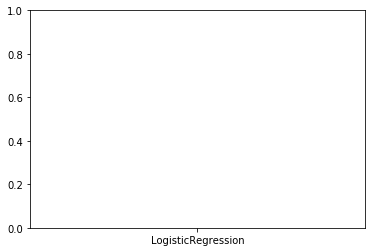

In [24]:
plt.hist(f1_ae64.keys(), f1_ae64.values())
plt.show()

<BarContainer object of 7 artists>

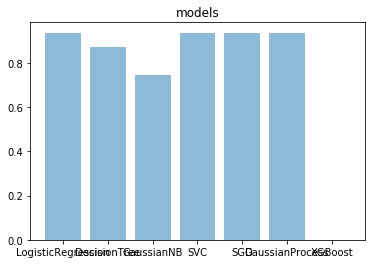

In [40]:

fig, axes = plt.subplots()
axes.set_title('models')
#axes.set_title('ConvAutoencoder')
axes.bar(f1_ae64.keys(), f1_ae64.values(), align='center', alpha=0.5)
#axes.legend()

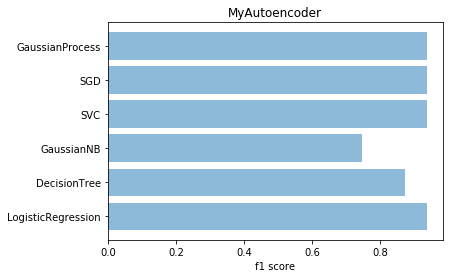

{'LogisticRegression': 0.935453435508905,
 'DecisionTree': 0.871321458830213,
 'GaussianNB': 0.7446741547761518,
 'SVC': 0.9356415433419567,
 'SGD': 0.9356415433419567,
 'GaussianProcess': 0.935806896480923,
 'XGBoost': 0}

In [53]:
keyes = ('LogisticRegression', 'DecisionTree', 'GaussianNB', 'SVC', 'SGD', 'GaussianProcess')
yyyy = range(6)
plt.barh(yyyy, list(f1_ae64.values())[:-1], align='center', alpha=0.5)
plt.yticks(yyyy, keyes)
plt.xlabel('f1 score')
plt.title('MyAutoencoder')
plt.show()
f1_ae64

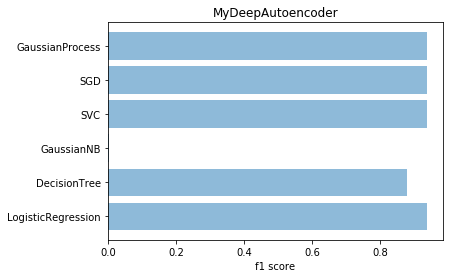

{'LogisticRegression': 0.9356415433419567,
 'DecisionTree': 0.8790662296575265,
 'GaussianNB': 0.003515384536887629,
 'SVC': 0.9356415433419567,
 'SGD': 0.9356415433419567,
 'GaussianProcess': 0.9356415433419567,
 'XGBoost': 0}

In [54]:
keyes = ('LogisticRegression', 'DecisionTree', 'GaussianNB', 'SVC', 'SGD', 'GaussianProcess')
yyyy = range(6)
plt.barh(yyyy, list(f1_dae64.values())[:-1], align='center', alpha=0.5)
plt.yticks(yyyy, keyes)
plt.xlabel('f1 score')
plt.title('MyDeepAutoencoder')
plt.show()
f1_dae64

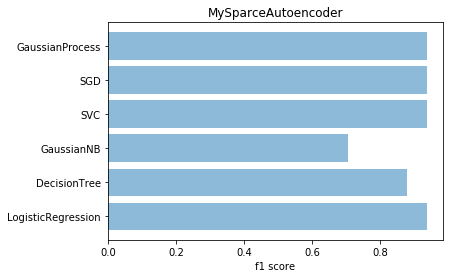

{'LogisticRegression': 0.9356415433419567,
 'DecisionTree': 0.8780698586127695,
 'GaussianNB': 0.7054006015573615,
 'SVC': 0.9356415433419567,
 'SGD': 0.9356415433419567,
 'GaussianProcess': 0.9356415433419567,
 'XGBoost': 0}

In [55]:
keyes = ('LogisticRegression', 'DecisionTree', 'GaussianNB', 'SVC', 'SGD', 'GaussianProcess')
yyyy = range(6)
plt.barh(yyyy, list(f1_sae64.values())[:-1], align='center', alpha=0.5)
plt.yticks(yyyy, keyes)
plt.xlabel('f1 score')
plt.title('MySparceAutoencoder')
plt.show()
f1_sae64

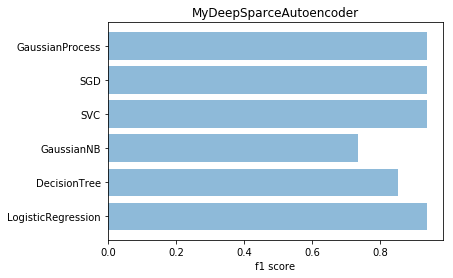

{'LogisticRegression': 0.9356415433419567,
 'DecisionTree': 0.8510729537540833,
 'GaussianNB': 0.7352653343351159,
 'SVC': 0.9356415433419567,
 'SGD': 0.9356415433419567,
 'GaussianProcess': 0.9356415433419567,
 'XGBoost': 0}

In [52]:
keyes = ('LogisticRegression', 'DecisionTree', 'GaussianNB', 'SVC', 'SGD', 'GaussianProcess')
yyyy = range(6)
plt.barh(yyyy, list(f1_dsae64.values())[:-1], align='center', alpha=0.5)
plt.yticks(yyyy, keyes)
plt.xlabel('f1 score')
plt.title('MyDeepSparceAutoencoder')
plt.show()
f1_dsae64

In [57]:
f1_union = {'LogisticRegression': [],
 'DecisionTree': [],
 'GaussianNB': [],
 'SVC': [],
 'SGD': [],
 'GaussianProcess': []
 }

it = [f1_ae64, f1_dae64, f1_sae64, f1_dsae64]
for f1 in it:
    for key, val in f1.items():
        if key != 'XGBoost':
            f1_union[key].append(val)
f1_union

{'LogisticRegression': [0.935453435508905,
  0.9356415433419567,
  0.9356415433419567,
  0.9356415433419567],
 'DecisionTree': [0.871321458830213,
  0.8790662296575265,
  0.8780698586127695,
  0.8510729537540833],
 'GaussianNB': [0.7446741547761518,
  0.003515384536887629,
  0.7054006015573615,
  0.7352653343351159],
 'SVC': [0.9356415433419567,
  0.9356415433419567,
  0.9356415433419567,
  0.9356415433419567],
 'SGD': [0.9356415433419567,
  0.9356415433419567,
  0.9356415433419567,
  0.9356415433419567],
 'GaussianProcess': [0.935806896480923,
  0.9356415433419567,
  0.9356415433419567,
  0.9356415433419567]}

{'LogisticRegression': [0.935453435508905,
  0.9356415433419567,
  0.9356415433419567,
  0.9356415433419567],
 'DecisionTree': [0.871321458830213,
  0.8790662296575265,
  0.8780698586127695,
  0.8510729537540833],
 'GaussianNB': [0.7446741547761518,
  0.003515384536887629,
  0.7054006015573615,
  0.7352653343351159],
 'SVC': [0.9356415433419567,
  0.9356415433419567,
  0.9356415433419567,
  0.9356415433419567],
 'SGD': [0.9356415433419567,
  0.9356415433419567,
  0.9356415433419567,
  0.9356415433419567],
 'GaussianProcess': [0.935806896480923,
  0.9356415433419567,
  0.9356415433419567,
  0.9356415433419567]}

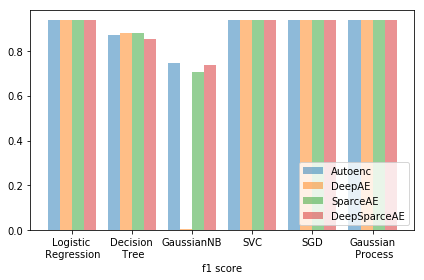

In [92]:
keyes = ('Logistic\n Regression', 'Decision\n Tree', 'GaussianNB', 'SVC', 'SGD', 'Gaussian\n Process')
yyyy = np.arange(6)
#plt.barh(yyyy, list(f1_union.values()), align='center', alpha=0.5)

bar_width = 0.2
plt.bar(yyyy + bar_width, list(f1_ae64.values())[:-1],bar_width, alpha=0.5, label='Autoenc')
plt.bar(yyyy + (bar_width * 2), list(f1_dae64.values())[:-1],bar_width, alpha=0.5, label='DeepAE')
plt.bar(yyyy + (bar_width * 3), list(f1_sae64.values())[:-1],bar_width, alpha=0.5, label='SparceAE')
plt.bar(yyyy + (bar_width * 4), list(f1_dsae64.values())[:-1],bar_width, alpha=0.5, label='DeepSparceAE')

plt.xticks(yyyy + 0.5, keyes)
plt.xlabel('f1 score')
#plt.title('MyDeepSparceAutoencoder')
plt.tight_layout()
plt.legend(loc='lower right')
f1_union

In [78]:
list(f1_ae64.values())[:-1]

[0.935453435508905,
 0.871321458830213,
 0.7446741547761518,
 0.9356415433419567,
 0.9356415433419567,
 0.935806896480923]

In [101]:
y

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [125]:
train, test, train_y, test_y, train_other, test_other = train_test_split(d2data64, y, other)

In [127]:
ae64 = MyAutoencoder64(20)
just_train(ae64, train, test, N, 0.001)

sae64 = MySparceAutoencoder64(20)
just_train(sae64, train, test, N, 0.001)

dae64 = MyDeepAutoencoder64(20)
just_train(dae64, train, test, N, 0.001)

dsae64 = MyDeepSparceAutoencoder64(20)
just_train(dsae64, train, test, N, 0.001)

Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10696.392/10566.120

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.021/0.021	Accuracy: 17846.174/17514.498

(0.02113079942543717, 0.02123637853757195, 17846.174, 17514.498)

In [126]:
сtrain, сtest, сtrain_y, сtest_y, ctrain_other, ctest_other = train_test_split(d3data128, y, other)

In [128]:
сae128 = MyCAutoencoder(20)
just_train(сae128, сtrain, сtest, N, 0.001)

Epoch 199... (Train/Test) MSE: 0.021/0.022	Accuracy: 92794.547/91860.633

(0.021455221987493774, 0.021557932355157707, 92794.55, 91860.63)

In [129]:
from sklearn.metrics import f1_score

def check_models(X_train, X_test, y_train, y_test):
    res = {'LogisticRegression': 0,
           'DecisionTree': 0,
           'GaussianNB': 0,
           'SVC': 0,
           'SGD': 0,
           'GaussianProcess': 0
          }
    #print metric
    lg = LogisticRegression(solver='liblinear', multi_class='auto')
    lg.fit(X_train, y_train)
    y_pred = lg.predict(X_test)
    res['LogisticRegression'] = f1_score(y_test, y_pred)
    
    dt = DecisionTreeClassifier(criterion='gini')
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    res['DecisionTree'] = f1_score(y_test, y_pred)
    
    bayes = GaussianNB()
    bayes.fit(X_train, y_train)
    y_pred = bayes.predict(X_test)
    res['GaussianNB'] = f1_score(y_test, y_pred)
    
    svc = SVC(kernel='rbf', shrinking=True, probability=False, degree=3, gamma='auto')
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    res['SVC'] = f1_score(y_test, y_pred)
    
    sgd = SGDClassifier(tol=1e-3, max_iter=1000, loss='hinge')
    sgd.fit(X_train, y_train)
    y_pred = sgd.predict(X_test)
    res['SGD'] = f1_score(y_test, y_pred)
    
    gp = GaussianProcessClassifier()
    gp.fit(X_train, y_train)
    y_pred = gp.predict(X_test)
    res['GaussianProcess'] = f1_score(y_test, y_pred)
    
    #gb = XGBClassifier(max_depth=10, n_estimators=20, booster='dart')
    #cv = cross_validate(gb, X, y, cv=10, scoring=metric)
    #res['XGBoost'] = np.mean(cv['test_score'])
    
    return res

In [144]:
X_train = ae64.encode(torch.Tensor(train))
X_train = pd.DataFrame(X_train)
X_train = pd.concat([X_train, pd.DataFrame(train_other.values)], axis=1)

X_test  = ae64.encode(torch.Tensor(test))
X_test = pd.DataFrame(X_test)
X_test = pd.concat([X_test, pd.DataFrame(test_other.values)], axis=1)
check_models(X_train, X_test, train_y, test_y)

{'LogisticRegression': 0.9301662707838481,
 'DecisionTree': 0.996687898089172,
 'GaussianNB': 0.7706698853349427,
 'SVC': 0.999490575649516,
 'SGD': 0.9294173377546188,
 'GaussianProcess': 1.0}

In [145]:
X_train = sae64.encode(torch.Tensor(train))
X_train = pd.DataFrame(X_train)
X_train = pd.concat([X_train, pd.DataFrame(train_other.values)], axis=1)

X_test  = sae64.encode(torch.Tensor(test))
X_test = pd.DataFrame(X_test)
X_test = pd.concat([X_test, pd.DataFrame(test_other.values)], axis=1)
check_models(X_train, X_test, train_y, test_y)

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


{'LogisticRegression': 0.9299242424242424,
 'DecisionTree': 0.996439471007121,
 'GaussianNB': 0.6875612144955926,
 'SVC': 0.9913309535951046,
 'SGD': 0.9299242424242424,
 'GaussianProcess': 1.0}

In [146]:
X_train = dae64.encode(torch.Tensor(train))
X_train = pd.DataFrame(X_train)
X_train = pd.concat([X_train, pd.DataFrame(train_other.values)], axis=1)

X_test  = dae64.encode(torch.Tensor(test))
X_test = pd.DataFrame(X_test)
X_test = pd.concat([X_test, pd.DataFrame(test_other.values)], axis=1)
check_models(X_train, X_test, train_y, test_y)

{'LogisticRegression': 0.9299242424242424,
 'DecisionTree': 1.0,
 'GaussianNB': 0.8913416727986265,
 'SVC': 1.0,
 'SGD': 0.897125567322239,
 'GaussianProcess': 1.0}

In [147]:
X_train = dsae64.encode(torch.Tensor(train))
X_train = pd.DataFrame(X_train)
X_train = pd.concat([X_train, pd.DataFrame(train_other.values)], axis=1)

X_test  = dsae64.encode(torch.Tensor(test))
X_test = pd.DataFrame(X_test)
X_test = pd.concat([X_test, pd.DataFrame(test_other.values)], axis=1)
check_models(X_train, X_test, train_y, test_y)

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


{'LogisticRegression': 0.9299242424242424,
 'DecisionTree': 1.0,
 'GaussianNB': 0.8913416727986265,
 'SVC': 0.9913309535951046,
 'SGD': 0.8937562940584088,
 'GaussianProcess': 1.0}

In [155]:
X_train = сae128.encode(torch.Tensor(сtrain))
X_train = pd.DataFrame(X_train)
X_train = pd.concat([X_train, pd.DataFrame(ctrain_other.values)], axis=1)

X_test  = сae128.encode(torch.Tensor(сtest))
X_test = pd.DataFrame(X_test)
X_test = pd.concat([X_test, pd.DataFrame(ctest_other.values)], axis=1)
check_models(X_train, X_test, сtrain_y, сtest_y)

{'LogisticRegression': 0.9374117647058824,
 'DecisionTree': 0.9984977466199298,
 'GaussianNB': 0.36208299430431246,
 'SVC': 0.9539049438738955,
 'SGD': 0.9379115710253998,
 'GaussianProcess': 0.9727704221833624}

In [156]:
of_ae = {'LogisticRegression': 0.9301662707838481,
 'DecisionTree': 0.996687898089172,
 'GaussianNB': 0.7706698853349427,
 'SVC': 0.999490575649516,
 'SGD': 0.9294173377546188,
 'GaussianProcess': 1.0}
of_sae = {'LogisticRegression': 0.9299242424242424,
 'DecisionTree': 0.996439471007121,
 'GaussianNB': 0.6875612144955926,
 'SVC': 0.9913309535951046,
 'SGD': 0.9299242424242424,
 'GaussianProcess': 1.0}
of_dae = {'LogisticRegression': 0.9299242424242424,
 'DecisionTree': 1.0,
 'GaussianNB': 0.8913416727986265,
 'SVC': 1.0,
 'SGD': 0.897125567322239,
 'GaussianProcess': 1.0}
of_dsae = {'LogisticRegression': 0.9299242424242424,
 'DecisionTree': 1.0,
 'GaussianNB': 0.8913416727986265,
 'SVC': 0.9913309535951046,
 'SGD': 0.8937562940584088,
 'GaussianProcess': 1.0}
of_cae = {'LogisticRegression': 0.9374117647058824,
 'DecisionTree': 0.9984977466199298,
 'GaussianNB': 0.36208299430431246,
 'SVC': 0.9539049438738955,
 'SGD': 0.9379115710253998,
 'GaussianProcess': 0.9727704221833624}


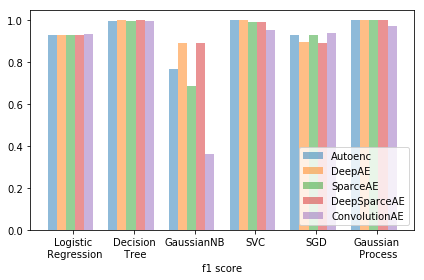

In [159]:
keyes = ('Logistic\n Regression', 'Decision\n Tree', 'GaussianNB', 'SVC', 'SGD', 'Gaussian\n Process')
yyyy = np.arange(6)
#plt.barh(yyyy, list(f1_union.values()), align='center', alpha=0.5)

bar_width = 0.15
plt.bar(yyyy + bar_width, list(of_ae.values()), bar_width, alpha=0.5, label='Autoenc')
plt.bar(yyyy + (bar_width * 2), list(of_dae.values()), bar_width, alpha=0.5, label='DeepAE')
plt.bar(yyyy + (bar_width * 3), list(of_sae.values()), bar_width, alpha=0.5, label='SparceAE')
plt.bar(yyyy + (bar_width * 4), list(of_dsae.values()), bar_width, alpha=0.5, label='DeepSparceAE')
plt.bar(yyyy + (bar_width * 5), list(of_cae.values()), bar_width, alpha=0.5, label='ConvolutionAE')

plt.xticks(yyyy + 0.5, keyes)
plt.xlabel('f1 score')
#plt.title('MyDeepSparceAutoencoder')
plt.tight_layout()
plt.legend(loc='lower right')